# Li-O$_2$ Battery cycle data processing

## Import necessary modules

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import os

%matplotlib inline 

## User inputs:

In [2]:
#Reference https://www.fuelcellstore.com/avcarb-mgl190
carb_area=(9**2)*np.pi #in mm^2
carb_v =  carb_area*0.19 #in mm^3
carb_den = 0.44*.001 #in g/mm^3
porosity = 0.78
carb_m = carb_v*carb_den*(1. - porosity) 

path = '/Users/decaluwe/OneDrive - Colorado School of Mines/CORES Research Group/Laboratory Resources/Gamry Data/Li-O2 Battery/20200317_50_40_10_CarbonCatalystBinder' #'C:/Users/Amy LeBar/Documents/Data'

# Set equal to 1 to see a graph, 0 to hide it:
flag_charge_discharge = 1
flag_voltage_gap = 0

# Number of cycles you are plotting:
n_cycles = 8
first_cycle = 2

# Plot file name preamble:
savename = '50_40_10_omit_cycle_1'

## Set up the color pallete and define the default font.

In [3]:
cmap = plt.get_cmap('plasma')
color_ind = np.linspace(0,1,n_cycles)
colors = list()
for i in np.arange(n_cycles):
    colors.append(cmap(color_ind[i]))

fontname = 'Times New Roman'

## Graphing function

In [4]:
def graph(file):
    Data = pd.read_table(file, sep='deliminator', engine='python', header=None)
    Data.dropna(inplace = True)
    Data = Data[0].str.split("\t", expand = True)

    # This means we cut the data when the time is zero.  To look at full data, 
    # use d_row = list(D[0]).index('#') + 1
    d_row = list(Data[1]).index('0') 
    Data = Data.iloc[d_row+1 : ,]

    Data[1] = Data[1].astype(float) # Time [s]
    Data[2] = Data[2].astype(float) # Voltage [V]
    Data[3] = Data[3].astype(float) # Current [A]
    
    Data['capacity'] = Data[1] * abs(Data[3])/carb_m*1000/3600 #convert to mAh/g
    title = file.split("_cycle")
    # Read out the cycle number:
    title2 = title[1].split(".")
    n_cycle = int(title2[0]) # cycle number
    i_cycle = n_cycle - first_cycle #python indexing starts at zero.
    
    #---SCD NOTE: IN GENERAL, CAN YOU DOCUMENT THESE LINES? WHAT DO THEY DO?---#
    for cell in Data[2]:
        if cell > Data.iloc[0,2]:
            row = list(Data[2]).index(cell)
            newc=Data.iloc[row:,2]
            Data['adjust']=newc
            Data['charge']=Data['adjust'].shift(-1*row)
            break
   
    Data['discharge'] = Data[2].where(Data[2]<=Data.iloc[0,2]) 
    
    Discharge = Data[Data[3] < 0][:]
    Charge = Data[Data[3] > 0][:]
    discharge_capacity = max(Discharge['capacity'])
    
    Charge['capacity'] = Charge['capacity'].iloc[:] - discharge_capacity
    charge_capacity = max(Charge['capacity'])
        
    plt.figure(0)
    p, = plt.plot(Discharge['capacity'], Discharge['charge'], \
            linewidth = 2., label = 'Cycle '+title2[0],color = colors[i_cycle], \
            zorder = 10*i_cycle)
    plt.plot(Discharge['capacity'], Discharge['discharge'], linewidth = 2., \
             label = '_nolegend_', color = colors[i_cycle], zorder = 10*i_cycle)
    
    Data['Voltgap'] = Data['charge'] -Data['discharge']
    
    Voltgap = Data.Voltgap.mean()
    Voltgap2 = 5
    return [Voltgap, Voltgap2, p, title2[0], discharge_capacity, charge_capacity]
#    plt.scatter(Data['capacity'], Data['Voltgap'], marker='o', label = title2)
#    plt.figure(1)
#    plt.scatter(D[1], D[3], marker='o')
#    plt.xlabel('time (s)', fontsize=12)
#    plt.ylabel('current (A)', fontsize=12)

## Loop through cycle files in director and plot them:

20200317_cv_cycle9.DTA
20200317_cv_cycle8.DTA
20200317_cv_cycle5.DTA
20200317_cv_cycle4.DTA
20200317_cv_cycle6.DTA
20200317_cv_cycle7.DTA
20200317_cv_cycle3.DTA
20200317_cv_cycle2.DTA


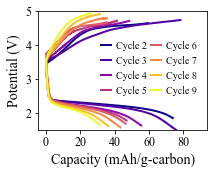

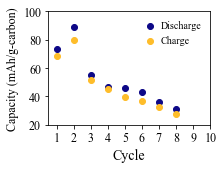

In [5]:
i=0
iform =[]
V = []
V2 = []
plots = {}

fig1 = plt.figure(0)
fig1.add_axes([0.2,0.25,0.78,0.73])
fig1.set_size_inches((3,2.25)) 

plt.xlabel('Capacity (mAh/g-carbon)', fontsize=14, fontname = 'Times New Roman')
plt.ylabel('Potential (V)', fontsize=14, fontname = 'Times New Roman')  

discharge_capacities = np.zeros(n_cycles)
charge_capacities = np.zeros(n_cycles)

for file in os.listdir(path):
    if file.find('cycle') > -1:
        if file.find('EIS') < 0:
            print(file)
            Voltgap_1, Voltgap_2, p, n, cap_d, cap_c =graph(path + "/"+ file)
            discharge_capacities[int(n)-first_cycle] = cap_d
            charge_capacities[int(n) - first_cycle] = cap_c
            #print(Voltgap)
            plots[n] = p
            V.append(Voltgap_1)
            V2.append(Voltgap_2)
            iform.append(i)
            i=i+1
   



#plt.xticks([0.00,1.00,2.,3.,4., ])
#plt.yticks([2.,2.5,3.,3.5,4.,4.5])

#plt.xlim([0.,4.5])
plt.ylim([1.5, 5.])


font = plt.matplotlib.font_manager.FontProperties(family=fontname,size=10,weight='normal')
legend_plots = []
legend_strings = []
for i in np.arange(n_cycles):
    legend_plots.append(plots[str(i+first_cycle)])
    legend_strings.append('Cycle '+str(i+first_cycle))
    
plt.legend(legend_plots, legend_strings, frameon = False, columnspacing = 0.35, \
           loc=(0.35,0.25), borderaxespad = 0.25, handletextpad = 0.5, prop=font, ncol=2, \
           handlelength=1.)

# Get current axes handle:
ax = plt.gca()

#Format tick labels:
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

plt.savefig(savename+'charge-discharge.pdf',format='pdf',dpi=350)
       
Report = pd.DataFrame()  
Report['V1'] = V
Report['V2'] = V2

if flag_voltage_gap:
    plt.figure(1)
    plt.scatter(iform, Report['V1'], marker='o')

    
# Plot capacity vs. cycle number:    
fig3 = plt.figure(2)
fig3.add_axes([0.2,0.25,0.75,0.7])
fig3.set_size_inches((3,2.25)) 

font = plt.matplotlib.font_manager.FontProperties(family=fontname,size=10,weight='normal')

plt.xlabel('Cycle', fontsize=14, fontname = 'Times New Roman')
plt.ylabel('Capacity (mAh/g-carbon)', fontsize=12, fontname = 'Times New Roman')

plt.scatter(np.arange(n_cycles)+1,discharge_capacities,marker='o',color=colors[0])
plt.scatter(np.arange(n_cycles)+1,charge_capacities,marker='o',color=colors[6])


# Get current axes handle:
ax = plt.gca()

#Format tick labels:
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylim([20., 100.])
plt.legend(['Discharge','Charge'], loc= 'upper right', frameon = False, prop=font, handletextpad = 0.01)

plt.savefig(savename+'capacity-vs-cycle.pdf',format='pdf',dpi=350)



## Now compare catalyst vs. non-catalyst:

In [6]:
#Reference https://www.fuelcellstore.com/avcarb-mgl190

path = '/Users/decaluwe/OneDrive - Colorado School of Mines/CORES Research Group/Laboratory Resources/Gamry Data/Li-O2 Battery/catalyst_comparison' #'C:/Users/Amy LeBar/Documents/Data'

# Set equal to 1 to see a graph, 0 to hide it:
flag_charge_discharge = 1
flag_voltage_gap = 0

# Number of cycles you are plotting:
n_cycles = 2


In [7]:
fontname = 'Times New Roman'

colors = [colors[0],colors[6]]#['r','b']

fontname = 'Times New Roman'

20200310_cv_cycle1.DTA
20200317_cv_cycle2.DTA


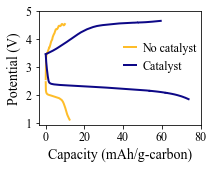

In [8]:
i=0
iform =[]
V = []
V2 = []
plots = {}

fig1 = plt.figure(0)
fig1.add_axes([0.2,0.25,0.75,0.7])
fig1.set_size_inches((3,2.25)) 

plt.xlabel('Capacity (mAh/g-carbon)', fontsize=14, fontname = 'Times New Roman')
plt.ylabel('Potential (V)', fontsize=14, fontname = 'Times New Roman')  

discharge_capacities = np.zeros(n_cycles)
charge_capacities = np.zeros(n_cycles)

iplot = 0
for file in os.listdir(path):
    if file.find('cycle') > -1:
        if file.find('EIS') < 0:
            print(file)
            Voltgap_1, Voltgap_2, p, n, cap_d, cap_c =graph(path + "/"+ file)
            discharge_capacities[int(n)-1] = cap_d
            charge_capacities[int(n) - 1] = cap_c
            #print(Voltgap)
            plots[str(iplot)] = p
            V.append(Voltgap_1)
            V2.append(Voltgap_2)
            iform.append(i)
            i=i+1
            iplot+=1
   

plt.xticks([0., 20., 40., 60., 80.])
plt.yticks([1., 2., 3., 4., 5.])

#plt.xlim([0.,4.5])
#plt.ylim([1.75, 4.75])

font = plt.matplotlib.font_manager.FontProperties(family=fontname,size=12,weight='normal')
legend_plots = []
for i in np.arange(n_cycles):
    legend_plots.append(plots[str(i)])
    
plt.legend(legend_plots, ['No catalyst','Catalyst'], frameon = False, columnspacing = 0.35,\
           loc=[0.5,0.42], borderaxespad = 0.25, handletextpad = 0.5, prop=font, ncol=1, \
           handlelength=1.)

# Get current axes handle:
ax = plt.gca()

#Format tick labels:
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
    
plt.savefig(savename+'_catalyst_comparison.pdf',format='pdf',dpi=350)

plt.show()
